In [311]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt
import itertools
import copy
from TrackReconstruction_functions import *


# infile ='../../NEXT_nudobe/files/data/Leptoquark_SM_nexus.h5'
infile = '../../NEXT_nudobe/files/data/Leptoquark_SM_1mm_smear.h5'

hits = pd.read_hdf(infile,"MC/hits")
parts = pd.read_hdf(infile,"MC/particles")

display(hits)


,event_id,x,y,z,energy
0,2850,-18.087435,-16.718485,-56.659714,0.002350
1,2850,-18.657701,-16.599083,-56.539867,0.001025
2,2850,-18.864998,-16.991850,-56.300049,0.007050
3,2850,-17.799454,-17.023008,-56.126163,0.003775
4,2850,-17.549644,-17.638756,-55.878799,0.001375
...,...,...,...,...,...
9343386,7299,-59.810055,-108.992561,1.571673,0.001250
9343387,7299,-60.376736,-104.863922,1.703859,0.001950
9343388,7299,-59.974476,-107.960136,1.788791,0.002325
9343389,7299,-60.275055,-106.016663,1.985682,0.003150


Energy Sum:  2.4580002


,x,y,z,energy
0,-89.009735,54.047352,75.282951,0.002675
1,-88.867249,53.002293,75.411461,0.001825
2,-88.788765,52.460087,75.492859,0.000025
3,-88.760498,54.879505,75.171700,0.003475
4,-88.660889,51.882416,75.622627,0.001400
...,...,...,...,...
1131,7.472411,-1.449334,-5.310735,0.001350
1132,7.495686,0.399020,-4.456613,0.000700
1133,7.512374,0.187865,-4.471508,0.001150
1134,7.639467,-1.097193,-5.155562,0.006525


Vertex Index is: 997


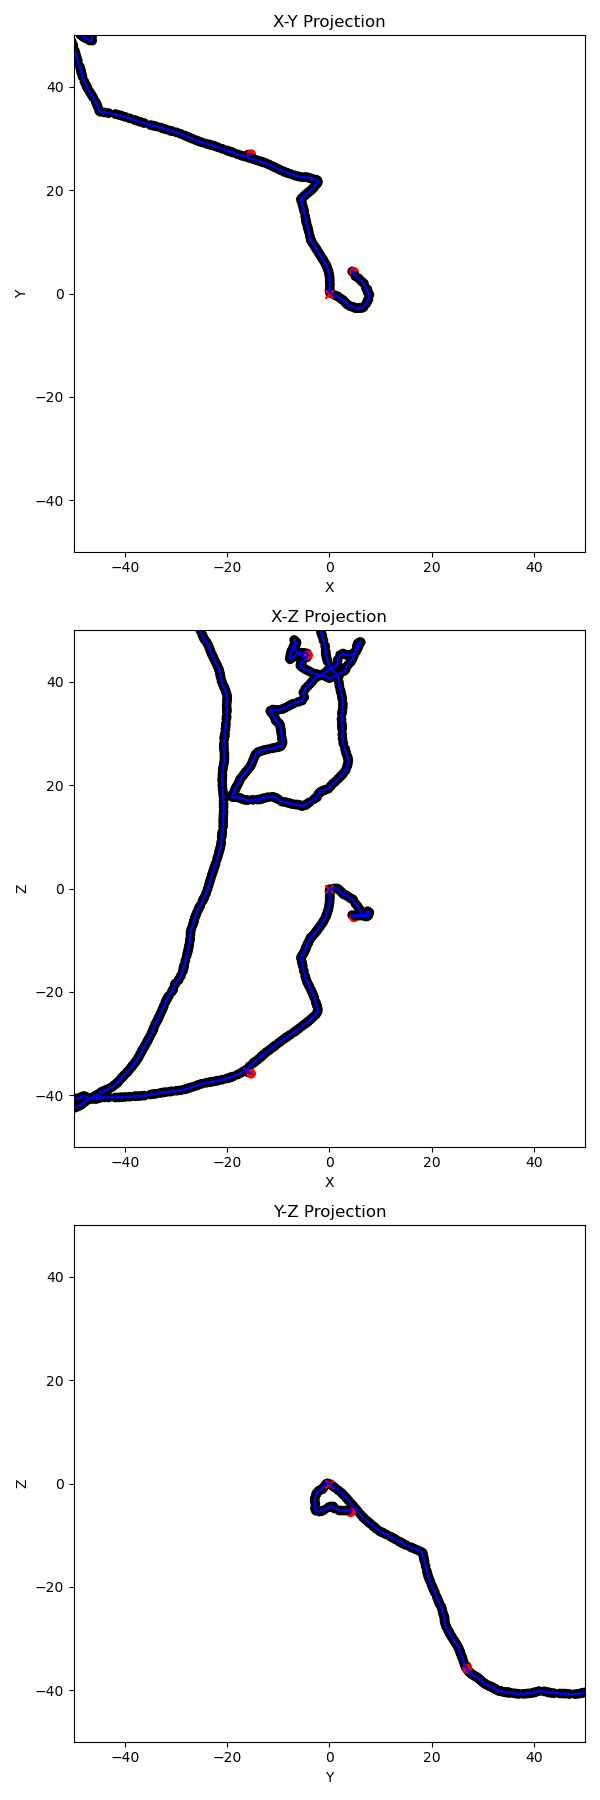

In [312]:
%matplotlib widget

event_num = 955

data = hits[hits.event_id == event_num]

# There seems to be a duplicate row sometimes
data = data.drop_duplicates()

# In the case of nexus, set the vertex to origin
if ("nexus" in infile):
    vertex = pd.DataFrame({'event_id': [event_num], 'x': [0], 'y': [0], 'z': [0], 'energy': [0]})
    data = pd.concat([data, vertex], ignore_index=True)

# display(data)
data = data[['x', 'y', 'z',"energy"]]

# shuffle the data to ensure we dont use g4 ordering
data = data.sample(frac=1).reset_index(drop=True)

# then sort it based on the x,y,z
data = data.sort_values(by=['x', "y", "z"]).reset_index(drop=True)

# Print energy sum
print("Energy Sum: ", data.energy.sum())

display(data)

# Calculate the distance matrix
dist_matrix = distance_matrix(data[['x', 'y', 'z']], data[['x', 'y', 'z']])

# Initialize connections counter, keeps track of number of connections to each index
connection_count = np.zeros(len(data), dtype=int)

# This is a dict, format is
# index : [connected node 1, connected node 2,...]
connected_nodes = {}

# Tunable parameters
init_dist_thresh = 15 # max distance for initial connections [mm]
incr_dist_thresh = [2,4,6,8,10,12,14,16,18,20] # Second stage, look for closest nodes, then slowly increase threshold [mm]
dist_threshold = 15 # Third distance threshold for conecting end nodes [mm]

connections = []

# -----------------------------------
# Find the node that is closest to the vertex
# Calculate the Euclidean distance from the origin for each row
data['distance'] = np.sqrt(data['x']**2 + data['y']**2 + data['z']**2)
vertex_index = data['distance'].idxmin()
# data = data.drop(columns=['distance'])
print("Vertex Index is:" , vertex_index)

# Make a connection to the two closest nodes
closest_idx = np.argsort(dist_matrix[vertex_index])[1:3]
UpdateConnections(vertex_index, closest_idx[0], connected_nodes, connections, connection_count)
UpdateConnections(vertex_index, closest_idx[1], connected_nodes, connections, connection_count)

# ------------------------------------
# Find closest nodes and create connections

for i in range(len(data)):
    # Find the index of the closest node (excluding itself)
    # closest_idx = np.argpartition(dist_matrix[i], 1)[1]
    closest_idx = np.argsort(dist_matrix[i])[1]
    
    # Check if the connection already exists 
    if closest_idx not in connected_nodes.get(i, []) and i not in connected_nodes.get(closest_idx, []):

        # Check the proposed node has 0 or 1 connection
        if (connection_count[closest_idx] <= 1 and connection_count[i] <= 1 and dist_matrix[i][closest_idx] < init_dist_thresh):
            
            cycle  = Testcycle(i, closest_idx ,connected_nodes, connections, connection_count)
            
            # Add connection between node i and closest_idx if it doesnt form a cycle
            if (not cycle):
                UpdateConnections(i, closest_idx, connected_nodes, connections, connection_count)

# Get indices where the value is 1
single_nodes = np.where(connection_count == 1)[0]

# Incrementally loop over distance steps looking for connections
# starting from a small step size helps lock onto the nearest nodes
for dist in incr_dist_thresh:

    # Connect single nodes to the next closest single node
    for i in single_nodes:
        
        # Connections get updated, so this ensures we dont make a connection to a newly formed connection
        if connection_count[i] == 1:
            
            # Find the index of the closest node with one connection (excluding itself)
            sorted_indices = np.argsort(dist_matrix[i])[1:]
            
            for closest_idx in sorted_indices[:dist]:

                # Check if the index is not itelf and the connection count of the closest index is 1
                if closest_idx != i and connection_count[closest_idx] <= 1 and connection_count[i] <= 1 and closest_idx not in connected_nodes.get(i, []) and i not in connected_nodes.get(closest_idx, []): 
                    
                    if dist_matrix[i][closest_idx] < dist:

                        cycle  = Testcycle(i, closest_idx ,connected_nodes, connections, connection_count)
                        
                        if not cycle:
                            UpdateConnections(i, closest_idx, connected_nodes, connections, connection_count)
                            break


# Function to plot connections
def plot_connections(ax, x, y, connections, connection_count, x_label, y_label):
    colors = ['r' if count == 1 or count == 0 else 'k' for count in connection_count]
    ax.scatter(x, y, c=colors, marker='o')
    ax.scatter(0, 0, c="r", marker='x')
    for connection in connections:
        start_node = connection[0]
        end_node = connection[1]
        ax.plot([x[start_node], x[end_node]], [y[start_node], y[end_node]], 'b-')
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(f'{x_label}-{y_label} Projection')
    ax.set_xlim(-50,50)
    ax.set_ylim(-50,50)

# Create subplots
fig, axs = plt.subplots(3, 1, figsize=(6, 18))

# Plot xy projection
plot_connections(axs[0], data['x'], data['y'], connections, connection_count, 'X', 'Y')

# Plot xz projection
plot_connections(axs[1], data['x'], data['z'], connections, connection_count, 'X', 'Z')

# Plot yz projection
plot_connections(axs[2], data['y'], data['z'], connections, connection_count, 'Y', 'Z')

plt.tight_layout()
plt.show()

{'id': 0, 'start': 722, 'end': 727, 'nodes': [722, 723, 727], 'length': 0.836, 'energy': 0.07067500241100788, 'label': 'track', 'c': (0.10588235294117647, 0.6196078431372549, 0.4666666666666667)}
{'id': 2, 'start': 900, 'end': 1108, 'nodes': [900, 891, 887, 869, 852, 847, 842, 824, 814, 812, 815, 818, 820, 823, 828, 832, 836, 838, 830, 827, 839, 835, 834, 829, 831, 841, 848, 874, 890, 860, 853, 851, 858, 870, 880, 898, 908, 921, 933, 938, 945, 966, 982, 993, 1021, 1031, 1044, 1056, 1079, 1081, 1086, 1094, 1098, 1103, 1106, 1112, 1114, 1117, 1122, 1123, 1120, 1118, 1115, 1113, 1109, 1104, 1102, 1099, 1096, 1091, 1085, 1074, 1075, 1054, 1045, 1042, 1036, 1030, 1019, 1000, 984, 967, 956, 943, 925, 916, 907, 896, 879, 867, 873, 861, 844, 822, 817, 809, 803, 797, 779, 770, 765, 758, 756, 760, 764, 768, 772, 773, 774, 777, 778, 784, 786, 788, 789, 790, 792, 793, 796, 800, 799, 794, 787, 785, 781, 776, 766, 759, 752, 750, 745, 741, 739, 736, 734, 733, 730, 728, 726, 725, 721, 717, 716, 713, 7

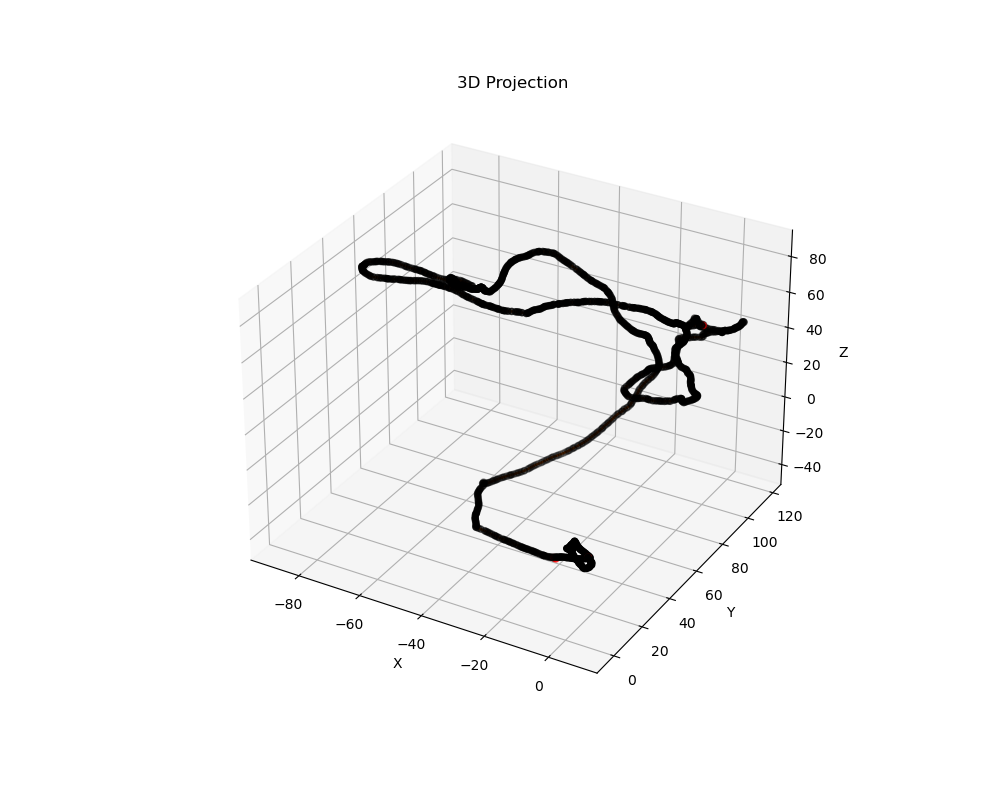

In [313]:
# Track building
colormap = plt.cm.get_cmap('Dark2')
color_cycle = itertools.cycle(colormap.colors)

# Get indices where the value is 1
single_nodes = np.where(connection_count == 1)[0]

Tracks = []

for i,node in enumerate(single_nodes):
    # Check that the track hasnt already been added
    if (check_start_end_exists(node,Tracks)):
        continue

    # Get the track path
    path = GetNodePath(connected_nodes, node, connected_nodes[node][0])

    total_length, total_energy = GetTrackLengthEnergy(path, data)
    color = next(color_cycle)

    Track = {"id":i, "start":path[0], "end":path[-1], "nodes":path, "length":total_length, "energy":total_energy,"label":"track","c":color}
    Tracks.append(Track)


for t in Tracks:
    print(t)

# Plot the labeled track
# Plot in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
colors = ['r' if count == 1 or count == 0 else 'k' for count in connection_count]
ax.scatter(data['x'], data['y'], data['z'], c=colors, marker='o')

for Track in Tracks:

    for i,connection in enumerate(Track["nodes"]):
            
            if (i == len(Track["nodes"])-1):
                break

            start_node = Track["nodes"][i]
            end_node = Track["nodes"][i+1]
   
            ax.plot([data['x'][start_node], data['x'][end_node]],
                    [data['y'][start_node], data['y'][end_node]],
                    [data['z'][start_node], data['z'][end_node]], color=Track["c"],linestyle="-")

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Projection')
plt.show()

# print(Tracks[1]["nodes"])
# print(GetNodePath(connected_nodes, 32, 27))
# print(GetNodePath(connected_nodes, 32, 41))


In [314]:
print(GetMeanNodeDist(Tracks, data))

dist_threshold = 4*GetMeanNodeDist(Tracks, data)
# dist_threshold = 10

0.642


In [315]:
# Now look to merge tracks that are close by and identify deltas

# search connections made and make sure to get the merged id
def GetDaughterConnectionID(id_, dict_):
    for ids in dict_:
        if (ids == id_):
            return GetDaughterConnectionID(dict_[id_], dict_)
        
    print("Daughter ID is: ",id_)
    return id_

# This adds the same track ID for the delta and the joining track
def AddConnectedTracksnoDelta(curr_track, conn_track, UpdatedTracks):

    print("Joining tracks ",curr_track,", ",conn_track)
    name = "track"
    color = "red"
    track_i_update = -1

    for index, t in enumerate(UpdatedTracks):
        
        # remove the old tracks
        if (t["id"] == curr_track):
            name = t["label"]
            color = t["c"]
            track_i_update = index

    # If the connecting track is a main track, then use the colour and label here
    for index, t in enumerate(UpdatedTracks):
        if (t["id"] == conn_track):
            if (t["label"] == "Track1" or t["label"] == "Track2"):
                name = t["label"]
                color = t["c"]


    UpdatedTracks[track_i_update]["label"] = name
    UpdatedTracks[track_i_update]["c"] = color

    for t in UpdatedTracks:
        print(t)

# Add in any nodes without connections to the tracks as gammas and re-label other tracks as gammas
AddConnectionlessNodes(connection_count, Tracks, data)

# ------------------------------------------------------
# Here we break the track containing the vertex ID in two 
for t in Tracks:

    # Found the track with the vertex
    if (vertex_index in t["nodes"]):
        # Get the length either side of track
        trk1_path = GetNodePath(connected_nodes, vertex_index, connected_nodes[vertex_index][0])[0:]
        trk2_path = GetNodePath(connected_nodes, vertex_index, connected_nodes[vertex_index][1])[0:]
        print("vertex:",vertex_index)
        print("Path1:",trk1_path)
        print("Path2:",trk2_path)
        CreateVertexandSplit(vertex_index, t["id"], trk1_path, trk2_path, Tracks, data)
        break

print("Printing Tracks")
for t in Tracks:
    print(t)

# ------------------------------------------------------



vertex: 997
Path1: [997, 991, 996, 998, 994, 995, 992, 989, 987, 985, 979, 976, 973, 964, 960, 959, 949, 944, 940, 932, 927, 923, 915, 912, 910, 905, 902, 899, 894, 886, 884, 882, 877, 872, 868, 864, 856, 854, 855, 857, 863, 865, 871, 876, 883, 892, 897, 904, 911, 913, 918, 922, 926, 931, 935, 937, 936, 929, 917, 909, 901, 889, 875, 859, 846, 837, 825, 813, 808, 806, 801, 791, 783, 771, 767, 762, 755, 751, 748, 744, 743, 740, 735, 731, 724, 718, 714, 710, 702, 691, 687, 686, 678, 633, 618, 611, 601, 596, 589, 580, 574, 569, 558, 549, 541, 533, 522, 514, 504, 500, 492, 486, 479, 470, 464, 458, 445, 436, 432, 428, 420, 412, 406, 401, 397, 388, 380, 374, 372, 369, 366, 362, 358, 345, 339, 329, 325, 319, 311, 302, 296, 291, 287, 281, 278, 275, 274, 271, 268, 263, 261, 258, 254, 251, 245, 240, 236, 231, 228, 223, 220, 218, 215, 213, 210, 208, 206, 203, 197, 201, 200, 195, 192, 193, 202, 204, 207, 211, 214, 217, 219, 222, 225, 226, 229, 233, 235, 238, 241, 244, 248, 249, 252, 255, 260, 264, 

0
Start, end: 0.6381850303914802 1.315876972964604
Connecting:  727 718
Joining tracks  0 ,  1
{'id': 0, 'start': 722, 'end': 727, 'nodes': [722, 723, 727], 'length': 0.836, 'energy': 0.07067500241100788, 'label': 'Track1', 'c': (0.4, 0.6509803921568628, 0.11764705882352941)}
{'id': 1, 'start': 997, 'end': 900, 'nodes': [997, 991, 996, 998, 994, 995, 992, 989, 987, 985, 979, 976, 973, 964, 960, 959, 949, 944, 940, 932, 927, 923, 915, 912, 910, 905, 902, 899, 894, 886, 884, 882, 877, 872, 868, 864, 856, 854, 855, 857, 863, 865, 871, 876, 883, 892, 897, 904, 911, 913, 918, 922, 926, 931, 935, 937, 936, 929, 917, 909, 901, 889, 875, 859, 846, 837, 825, 813, 808, 806, 801, 791, 783, 771, 767, 762, 755, 751, 748, 744, 743, 740, 735, 731, 724, 718, 714, 710, 702, 691, 687, 686, 678, 633, 618, 611, 601, 596, 589, 580, 574, 569, 558, 549, 541, 533, 522, 514, 504, 500, 492, 486, 479, 470, 464, 458, 445, 436, 432, 428, 420, 412, 406, 401, 397, 388, 380, 374, 372, 369, 366, 362, 358, 345, 339, 32

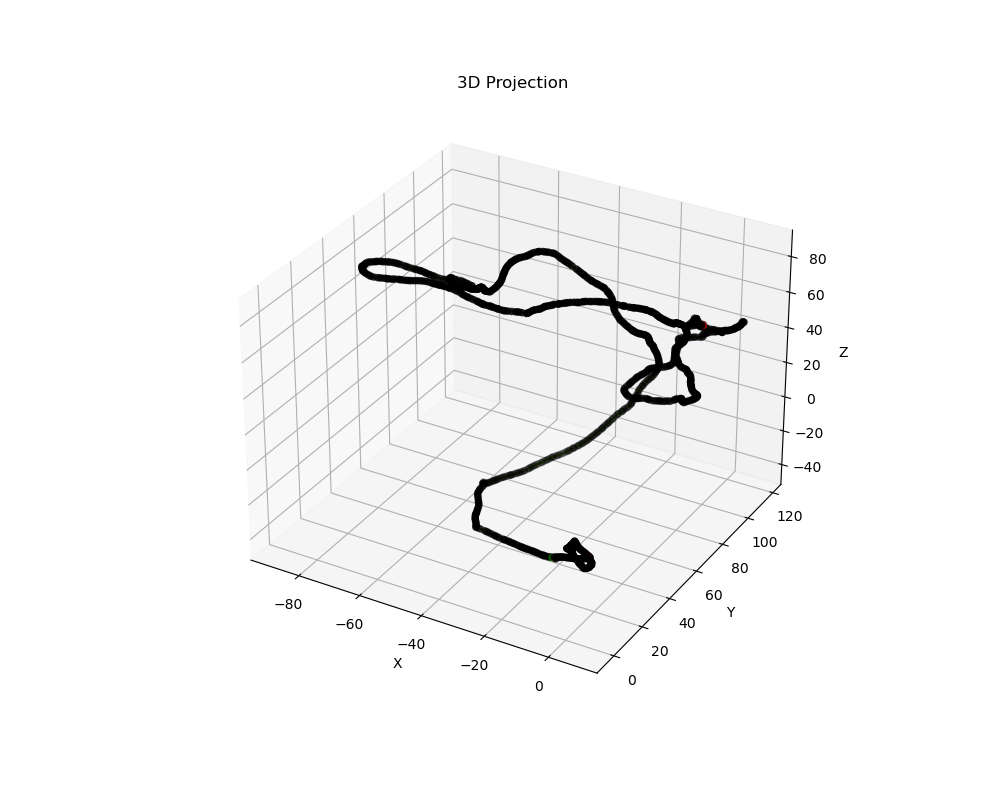

In [316]:


UpdatedTracks = copy.deepcopy(Tracks)

for idx, Track in enumerate(Tracks):
    curr_track = Track["id"]
    print(curr_track)
    curr_label = Track["label"]

    if (curr_label== "vertex"):
        print("Skipping Vertex...")
        continue
    
    primary_track = False
    if (curr_label == "Track1" or curr_label == "Track2"):
        primary_track = True

    start_node = Track["start"]
    end_node   = Track["end"]

    # dont run this if we only got one track!
    if (len(Tracks) == 1):
        break

    # Get the indexes of closest nodes to start and end
    dist_ind_start = np.argsort(dist_matrix[start_node])[1:]
    dist_ind_end   = np.argsort(dist_matrix[end_node])[1:]

    # Filter nodes that are in the current track
    dist_ind_start = [x for x in dist_ind_start if x not in Track["nodes"]]
    dist_ind_end   = [x for x in dist_ind_end if x not in Track["nodes"]]

    # Distances of the end point to the closest track
    dist_start = dist_matrix[start_node][dist_ind_start[0]]
    dist_end   = dist_matrix[end_node][dist_ind_end[0]]

    # apply threshold
    if (dist_start > dist_threshold and dist_end > dist_threshold):
        print("Failed distance requirements")
        continue

    # Initialize
    closest_idx = 0
    end_conn_node = 0
    con_point = "start"
    curr_track_path = Track["nodes"]
    con_track_label = ""
    temp_dist = 0

    # Get the track labels of the connecting track
    start_con_track_label = GetTrackDictwithNode(dist_ind_start[0], Tracks)["label"]
    end_con_track_label   = GetTrackDictwithNode(dist_ind_end[0], Tracks)["label"]

    start_primary = False
    end_primary = False
    if ( start_con_track_label == "Track1" or start_con_track_label == "Track2"):
        start_primary = True
    
    if ( end_con_track_label == "Track1" or end_con_track_label != "Track2"):
        end_primary = True

    # Choose the smallest index
    if ( (dist_start < dist_end or dist_ind_end[0] == vertex_index) and (primary_track and not start_primary)  ):
        closest_idx = dist_ind_start[0]
        end_conn_node = start_node
        con_track_label = start_con_track_label
        temp_dist = dist_start
        
    else:
        closest_idx = dist_ind_end[0]
        end_conn_node = end_node
        con_point = "end"
        con_track_label = end_con_track_label
        temp_dist = dist_end

    print( "Start, end:", dist_start, dist_end)

    # Skip if we are trying to reconnect to a vertex
    if (closest_idx == vertex_index):
        print("Trying to connect to vertex, skipping...")
        continue

    if (( con_track_label == "Track1" or con_track_label == "Track2") and primary_track ):
        print("Trying to connect two primaries, skipping...")
        continue

    if (temp_dist > dist_threshold):
        print("Does not satisfy distance requreiments, skipping...")
        continue


    # Get the track ID where the connecting node is located
    con_track      = GetTrackwithNode(closest_idx, Tracks)
    con_track_dict = GetTrackDictwithNode(closest_idx, Tracks)

    if (con_track_dict == -1):
        print("Connecting track could not be found...")
        continue

    if (connection_count[closest_idx] == 3 or connection_count[end_conn_node] == 3):
        print("node already has three connecitons,skipping...")
        continue

    # if node-node then merge nodes and update track in Tracks
    if (closest_idx == con_track_dict["start"] or closest_idx == con_track_dict["end"]):
         
        newpath = join_tracks(curr_track_path,con_track_dict["nodes"])
        UpdateAndMergeTrack(curr_track, con_track, newpath, UpdatedTracks, data)
        UpdateConnections(end_conn_node, closest_idx, connected_nodes, connections, connection_count)
        print("node-node connection",curr_track,con_track  )
        continue

    # Check if the proposed connection will form a cycle
    cycle  = Testcycle(end_conn_node, closest_idx ,connected_nodes, connections, connection_count)
    
    if not cycle:

        if (con_point =="start"):
            curr_track_path.insert(0,closest_idx)
        else:
            curr_track_path.append(closest_idx)

        Track["nodes"] = curr_track_path
        print("Connecting: ",end_conn_node, closest_idx)
        UpdateConnections(end_conn_node, closest_idx, connected_nodes, connections, connection_count)
    else:
        continue

    # Combine the track labels
    AddConnectedTracksnoDelta(curr_track, con_track, UpdatedTracks)


FixTrackEnergies(UpdatedTracks,vertex_index, data)


e_sum = 0
track_id_list = []
for t in UpdatedTracks:
    print(t)
    if t["id"] not in track_id_list:
        track_id_list.append(t["id"])

        
    e_sum+=t["energy"]

print("Tot Energy: ",e_sum)
print("Total Tracks:", len(UpdatedTracks))
print("Total Unique:", len(track_id_list))

# Plot the labeled track
# Plot in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
colors = ['r' if count == 1 or count == 0 else 'g' if count == 3 else 'k' for count in connection_count]
ax.scatter(data['x'], data['y'], data['z'], c=colors, marker='o')

for Track in UpdatedTracks:

    for i,connection in enumerate(Track["nodes"]):
            
            if (i == len(Track["nodes"])-1):
                break

            start_node = Track["nodes"][i]
            end_node = Track["nodes"][i+1]
   
            ax.plot([data['x'][start_node], data['x'][end_node]],
                    [data['y'][start_node], data['y'][end_node]],
                    [data['z'][start_node], data['z'][end_node]], color=Track["c"],linestyle="-")

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Projection')
plt.show()



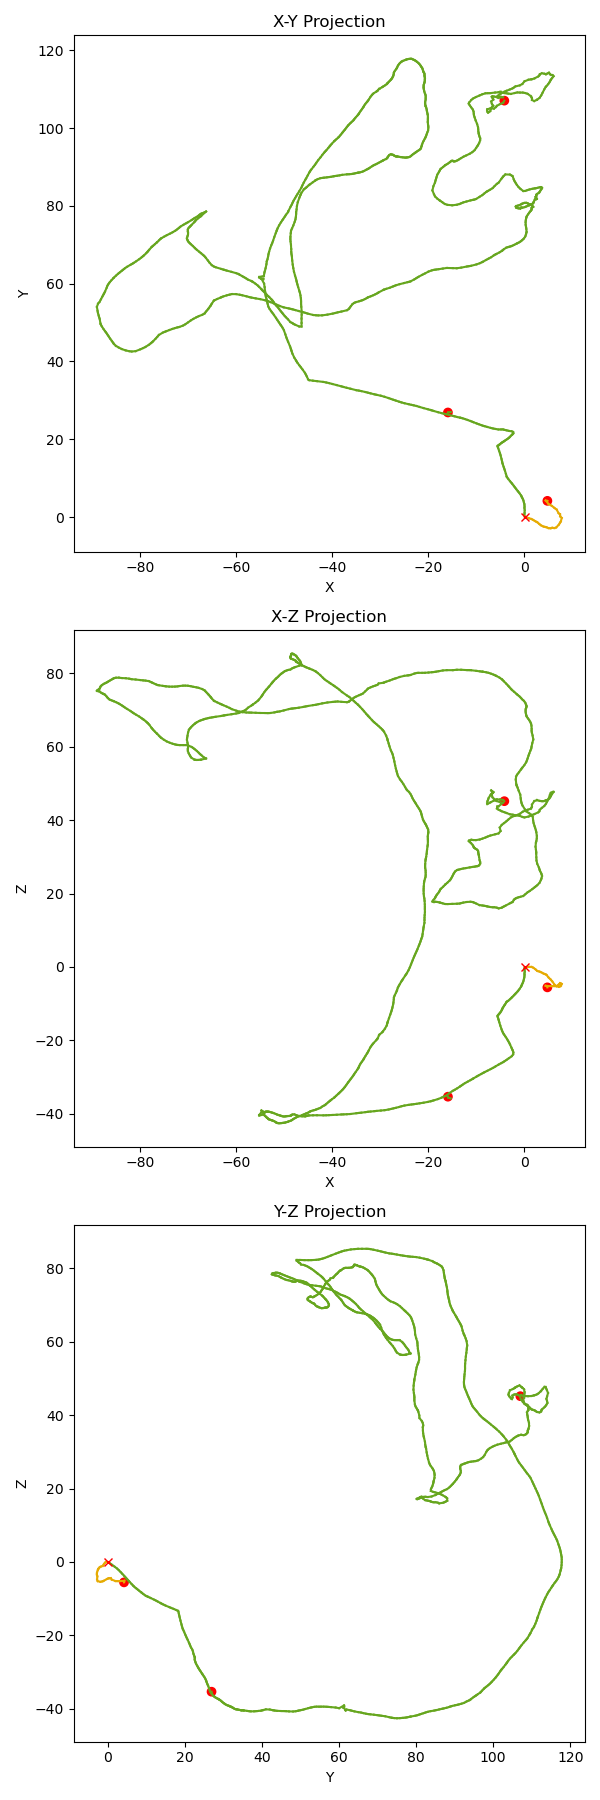

In [317]:
# Function to plot connections
def plot_tracks(ax, x, y, connection_count, x_label, y_label, UpdatedTracks):
    # Filter data for markers with count 1 or 0
    filtered_indices = [i for i, count in enumerate(connection_count) if count == 1 or count == 0]
    filtered_x = [x[i] for i in filtered_indices]
    filtered_y = [y[i] for i in filtered_indices]
    
    # Define colors for filtered data
    colors = ['r' if connection_count[i] == 1 else 'Orange' for i in filtered_indices]
    
    # Plot filtered markers
    ax.scatter(filtered_x, filtered_y, c=colors, marker='o')

    # Plot connections
    for Track in UpdatedTracks:
        for i, connection in enumerate(Track["nodes"]):
            if i == len(Track["nodes"]) - 1:
                break

            start_node = Track["nodes"][i]
            end_node = Track["nodes"][i + 1]

            ax.plot([x[start_node], x[end_node]],
                    [y[start_node], y[end_node]], color=Track["c"], linestyle="-")
            
        if (Track["label"] == "vertex"):
            ax.plot(x[Track["start"]], y[Track["start"]], marker = "x", color = "r" )
    
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(f'{x_label}-{y_label} Projection')


# Create subplots
fig, axs = plt.subplots(3, 1, figsize=(6, 18))

# Plot xy projection
plot_tracks(axs[0], data['x'], data['y'], connection_count, 'X', 'Y', UpdatedTracks)

# Plot xz projection
plot_tracks(axs[1], data['x'], data['z'], connection_count, 'X', 'Z', UpdatedTracks)

# Plot yz projection
plot_tracks(axs[2], data['y'], data['z'], connection_count, 'Y', 'Z', UpdatedTracks)

plt.tight_layout()
plt.show()

In [318]:
# Reconstruction level quantities

# Add gamma energy to the lowest energy track

track1_energy = 0
track2_energy = 0

for t in UpdatedTracks:

    if (t["label"] == "Track1"):
        track1_energy = track1_energy + t["energy"]

    if (t["label"] == "Track2"):
        track2_energy = track2_energy + t["energy"]

# ID the track with the lowest label
highest_track = "Track2"
if (track1_energy > track2_energy):
    highest_track = "Track1"

e_gammas = 0
for t in UpdatedTracks:

    if (t["label"] != "Track1" and t["label"] != "Track2"):
        print(t["label"])
        e_gammas = e_gammas + t["energy"]

print("Gamma Energy:",e_gammas)

if (highest_track == "Track1"):
    track1_energy = track1_energy + e_gammas
else:
    track2_energy = track2_energy + e_gammas

print("Track 1 Energy:", track1_energy)
print("Track 2 Energy:", track2_energy)
print("Tot Energy:", track1_energy + track2_energy)
Reco_T1 = ReturnLargest(track1_energy,track2_energy)


part = parts[parts.event_id == event_num]
part = part[part.primary == 1]
display(part)

gen_kin_energy = max(part.kin_energy.values) # generator T1

vertex
Gamma Energy: 0
Track 1 Energy: 2.251712505958494
Track 2 Energy: 0.20628750073592528
Tot Energy: 2.4580000066944194


,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,...,initial_momentum_x,initial_momentum_y,initial_momentum_z,final_momentum_x,final_momentum_y,final_momentum_z,kin_energy,length,creator_proc,final_proc
73244,955,2,e-,1,0,0.0,0.0,0.0,0.0,-5.435205,...,0.107831,2.176746,-1.619830,-0.0,0.0,-0.0,2.252119,765.223999,none,eIoni
73263,955,1,e-,1,0,0.0,0.0,0.0,0.0,4.479354,...,0.286741,0.046127,-0.410371,-0.0,0.0,-0.0,0.205850,28.251648,none,eIoni


In [319]:
# Calculate the angle between the electrons

### ------------- ------------- ------------- -------------
# Filter particles with particle_id 1 and 2
particle_1 = part[part.particle_id == 1].copy()
particle_2 = part[part.particle_id == 2].copy()

# Merge the DataFrames on 'event' to pair particles from the same event
merged_particles = pd.merge(particle_1, particle_2, on="event_id", suffixes=('_1', '_2'))

# Apply the function to each row in the merged DataFrame
merged_particles['angle'] = merged_particles.apply(calculate_angle_parts, axis=1)
print("True Angle:", merged_particles['angle'].iloc[0])
# ------------- ------------- ------------- -------------

data['Track1'] = 0
data['Track2'] = 0

track1_indices = []
track2_indices = []

for t in UpdatedTracks:

    if t["label"] == "Track1":
        track1_indices = track1_indices + t["nodes"]

    if t["label"] == "Track2":
        track2_indices = track2_indices + t["nodes"]

data.loc[track1_indices, 'Track1'] = 1
data.loc[track2_indices, 'Track2'] = 1

display(data[data.distance < 5])

print(track1_indices)


True Angle: 0.5831148766943732


,x,y,z,energy,distance,Track1,Track2
989,-0.034346,3.697672,-3.216710,0.002325,4.901141,1,0
991,0.043879,0.583038,-0.432578,0.000750,0.727312,1,0
992,0.044810,3.299770,-2.759730,0.002775,4.301930,1,0
994,0.068634,2.358918,-1.795055,0.001675,2.965034,1,0
995,0.076865,2.780754,-2.206364,0.003050,3.550569,1,0
996,0.082490,1.046390,-0.775331,0.002375,1.304942,1,0
997,0.116095,0.144276,-0.123481,0.003325,0.222578,1,1
998,0.116514,1.751843,-1.305177,0.001125,2.187697,1,0
1023,1.002165,-0.298419,0.021412,0.003200,1.045871,0,1
1037,1.536030,-0.498108,-0.004410,0.000050,1.614781,0,1


[722, 723, 727, 997, 991, 996, 998, 994, 995, 992, 989, 987, 985, 979, 976, 973, 964, 960, 959, 949, 944, 940, 932, 927, 923, 915, 912, 910, 905, 902, 899, 894, 886, 884, 882, 877, 872, 868, 864, 856, 854, 855, 857, 863, 865, 871, 876, 883, 892, 897, 904, 911, 913, 918, 922, 926, 931, 935, 937, 936, 929, 917, 909, 901, 889, 875, 859, 846, 837, 825, 813, 808, 806, 801, 791, 783, 771, 767, 762, 755, 751, 748, 744, 743, 740, 735, 731, 724, 718, 714, 710, 702, 691, 687, 686, 678, 633, 618, 611, 601, 596, 589, 580, 574, 569, 558, 549, 541, 533, 522, 514, 504, 500, 492, 486, 479, 470, 464, 458, 445, 436, 432, 428, 420, 412, 406, 401, 397, 388, 380, 374, 372, 369, 366, 362, 358, 345, 339, 329, 325, 319, 311, 302, 296, 291, 287, 281, 278, 275, 274, 271, 268, 263, 261, 258, 254, 251, 245, 240, 236, 231, 228, 223, 220, 218, 215, 213, 210, 208, 206, 203, 197, 201, 200, 195, 192, 193, 202, 204, 207, 211, 214, 217, 219, 222, 225, 226, 229, 233, 235, 238, 241, 244, 248, 249, 252, 255, 260, 264, 266,

In [320]:
# Given vertex position
vertex = data[ (data.Track1 == 1) & (data.Track2 == 1)]
vertex = np.array([vertex.iloc[0].x,vertex.iloc[0].y,vertex.iloc[0].z])
vertex = np.array([0,0,0])

# Track1 = data[ (data.Track1 == 1) & (data.Track2 != 1)]
Track1 = data.iloc[trk1_path]
# Track1 = Track1.reindex(track1_indices)
Track1 = Track1.iloc[1:] # remove vertex index

# Track2 = data[ (data.Track2 == 1) & (data.Track1 != 1)]
Track2 = data.iloc[trk2_path]
# Track2 = Track2.reindex(track2_indices)
Track2 = Track2.iloc[1:] # remove vertex index

display(Track1)
display(Track2)

# cos_theta, direction_vector1, direction_vector2 = CalcTrackAngle(Track1.iloc[0:1], Track2.iloc[0:1], vertex)
cos_theta, direction_vector1, direction_vector2 = CalcTrackAngle(Track1, Track2, vertex)

print(cos_theta)

,x,y,z,energy,distance,Track1,Track2
991,0.043879,0.583038,-0.432578,0.000750,0.727312,1,0
996,0.082490,1.046390,-0.775331,0.002375,1.304942,1,0
998,0.116514,1.751843,-1.305177,0.001125,2.187697,1,0
994,0.068634,2.358918,-1.795055,0.001675,2.965034,1,0
995,0.076865,2.780754,-2.206364,0.003050,3.550569,1,0
...,...,...,...,...,...,...,...
852,-5.661067,105.722878,45.676247,0.002925,115.306953,1,0
869,-5.029662,106.146202,45.648605,0.005425,115.655128,1,0
887,-4.445713,106.448097,45.521130,0.000650,115.858253,1,0
891,-4.377327,106.504379,45.501617,0.000050,115.899704,1,0


,x,y,z,energy,distance,Track1,Track2
1023,1.002165,-0.298419,0.021412,0.003200,1.045871,0,1
1037,1.536030,-0.498108,-0.004410,0.000050,1.614781,0,1
1052,1.910105,-0.746417,-0.229472,0.002075,2.063564,0,1
1059,2.363011,-1.080669,-0.664644,0.000725,2.682055,0,1
1077,2.729380,-1.322505,-1.086185,0.001800,3.221542,0,1
1082,3.186314,-1.802462,-1.270999,0.002800,3.875165,0,1
1090,3.543168,-2.133364,-1.465633,0.000350,4.387865,0,1
1097,4.060503,-2.434716,-1.824233,0.006500,5.073791,0,1
1100,4.398676,-2.527099,-1.995566,0.003400,5.451318,0,1
1105,4.661095,-2.609632,-2.179634,0.004075,5.769470,0,1


-0.1830983882576271


(-2.0, 2.0)

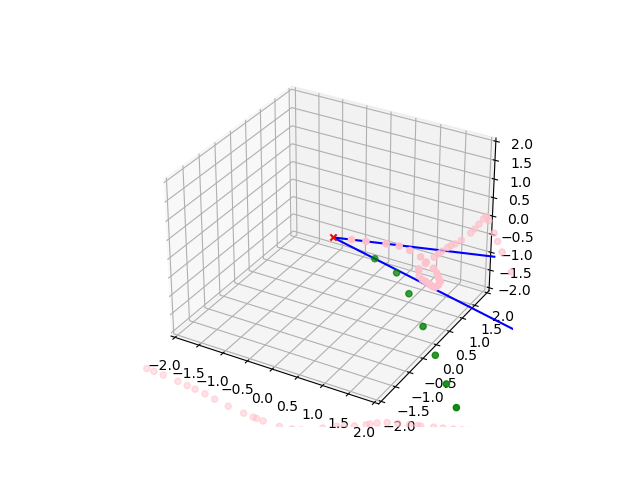

In [321]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the original points
# ax.scatter(data.x, data.y, data.z, color='blue')
ax.scatter(vertex[0], vertex[1], vertex[2], color='red', marker="x")
ax.scatter(Track1.x, Track1.y, Track1.z, color='pink')
ax.scatter(Track2.x, Track2.y, Track2.z, color='green')

# Plot the direction vector
vector_line1 = np.array([vertex, vertex + 10*direction_vector1])  # Extend the vector for visualization
vector_line2 = np.array([vertex, vertex + 10*direction_vector2])  # Extend the vector for visualization

ax.plot(vector_line1[:, 0], vector_line1[:, 1], vector_line1[:, 2], color='blue')
ax.plot(vector_line2[:, 0], vector_line2[:, 1], vector_line2[:, 2], color='blue')

ax.set_xlim(-2,2)
ax.set_ylim(-2,2)
ax.set_zlim(-2,2)